# Surface radiation field tools

In this tutorial we demonstrate usage of several tools for checking the implementation of a surface radiation field extension module.

The unexecuted notebook for this tutorial may be found in a GitHub repository:

``` bash
git clone https://github.com/ThomasEdwardRiley/xpsi_workshop.git </path/to/clone>

cd </path/to/clone>/tutorials/v0.6/
```

To run this tutorial, you'll need to change the atmosphere extensions as instructed below. Moreover, you'll need numerical atmosphere data. The data used for this tutorial is not the intellectual property of the X-PSI team so we do not distribute it. The author of the atmosphere model data is listed where relevant below.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')
import numpy as np

In [2]:
import xpsi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|               Version: 0.7.10               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


In [3]:
from matplotlib import pyplot as plt
plt.rc('font', size=20.0)

## Calculate the specific intensity directly from local variables

In [22]:
# keV (local comoving frame)
E = np.logspace(-2.0, 0.5, 1000, base=10.0)

# cos(angle to local surface normal in comoving frame)
mu = np.ones(1000) * 0.5

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.11, 13.8]]*1000)

In [23]:
#print(E, mu, local_vars)

(array([0.01      , 0.01005779, 0.01011591, 0.01017437, 0.01023317,
       0.0102923 , 0.01035178, 0.0104116 , 0.01047177, 0.01053228,
       0.01059315, 0.01065436, 0.01071593, 0.01077786, 0.01084014,
       0.01090279, 0.01096579, 0.01102916, 0.0110929 , 0.011157  ,
       0.01122148, 0.01128633, 0.01135155, 0.01141715, 0.01148312,
       0.01154948, 0.01161623, 0.01168335, 0.01175087, 0.01181878,
       0.01188708, 0.01195577, 0.01202486, 0.01209435, 0.01216424,
       0.01223454, 0.01230524, 0.01237635, 0.01244787, 0.01251981,
       0.01259216, 0.01266492, 0.01273811, 0.01281172, 0.01288576,
       0.01296023, 0.01303512, 0.01311045, 0.01318621, 0.01326242,
       0.01333906, 0.01341614, 0.01349367, 0.01357165, 0.01365008,
       0.01372896, 0.0138083 , 0.01388809, 0.01396835, 0.01404907,
       0.01413026, 0.01421192, 0.01429405, 0.01437665, 0.01445973,
       0.01454329, 0.01462733, 0.01471186, 0.01479688, 0.01488239,
       0.01496839, 0.01505489, 0.01514189, 0.0152294 , 0.0153

In [24]:
xpsi.surface_radiation_field?

In [25]:
xpsi.surface_radiation_field.intensity?

In [26]:
### Isotropic blackbody

For the following cell, compile `xpsi/surface_radiation_field/archive/hot/blackbody.pyx` radiation field as the `hot.pyx` extension (or leave the default X-PSI extension as is if you haven't changed it before):

### Numerical atmosphere

Let's check out a numerical atmosphere (this code you typically find in a custom photosphere class). The numerical atmospheres loaded here were generated by the NSX atmosphere code ([Ho, W.C.G & Lai, D. 2001](https://ui.adsabs.harvard.edu/abs/2001MNRAS.327.1081H/abstract); [Ho, W.C.G & Heinke, C.O. 2009](https://ui.adsabs.harvard.edu/link_gateway/2009Natur.462...71H/doi:10.1038/nature08525)), courtesy of W.C.G. Ho for NICER modeling efforts. One of these atmospheres (fully-ionized hydrogen; Ho & Lai 2001) was used in [Riley et al. (2019)](applications.rst#riley-et-al-2019-apjl-887-l21); also see Bogdanov et al. (2020). If you want to model data conditional on one of the NSX atmosphere models, and in particular this numerical data, we advise you get in touch with Wynn Ho (Haverford) for access.

Next compile the `archive/hot/numerical.pyx` radiation field as the `hot.pyx` extension, and compile the `archive/elsewhere/numerical.pyx` radiation field as the `elsewhere.pyx` extension. The numerical extensions infer the size of the parameter grid, but are hard-coded for four-dimensional cubic polynomial interpolation. To do this, change the contents of the target extension files, and reinstall X-PSI, and then restart your IPython kernel, **and run all cells above, apart from [7]**. Then continue cell execution below.

In [27]:
def preload(path, size):
    NSX = np.loadtxt(path, dtype=np.double)
    logT = np.zeros(size[0])
    logg = np.zeros(size[1])
    _mu = np.zeros(size[2]) # use underscore to bypass errors with the other mu array
    logE = np.zeros(size[3])

    reorder_buf = np.zeros(size)

    index = 0
    for i in range(reorder_buf.shape[0]):
        for j in range(reorder_buf.shape[1]):
            for k in range(reorder_buf.shape[3]):
               for l in range(reorder_buf.shape[2]):
                    logT[i] = NSX[index,3]
                    logg[j] = NSX[index,4]
                    logE[k] = NSX[index,0]
                    _mu[reorder_buf.shape[2] - l - 1] = NSX[index,1]
                    reorder_buf[i,j,reorder_buf.shape[2] - l - 1,k] = 10.0**(NSX[index,2])
                    index += 1

    buf = np.zeros(np.prod(reorder_buf.shape))

    bufdex = 0
    for i in range(reorder_buf.shape[0]):
        for j in range(reorder_buf.shape[1]):
            for k in range(reorder_buf.shape[2]):
               for l in range(reorder_buf.shape[3]):
                    buf[bufdex] = reorder_buf[i,j,k,l]; bufdex += 1

    atmosphere = (logT, logg, _mu, logE, buf)
    
    return atmosphere

In [28]:
H_fully = preload('/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019.out',
                    size=(35, 11, 67, 166))

In [29]:
He_fully = preload('/home/bas/Documents/Projects/x-psi/model_datas/model_data/He-atmosphere_Spectra_fully_ionized/NSX_He-atmosphere_Spectra/nsx_He_v170925.out',
                      size=(29, 11, 67, 166))

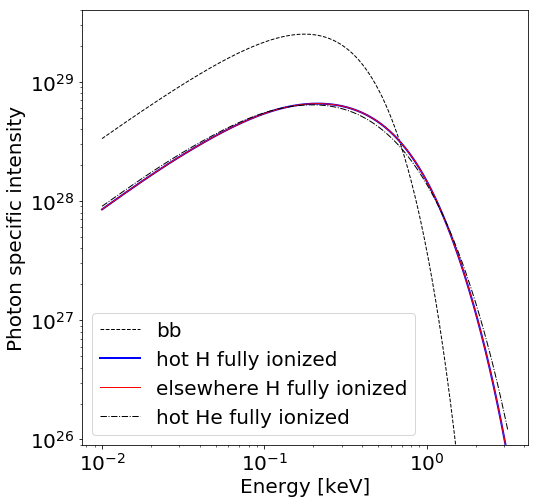

In [33]:
plt.figure(figsize=(8,8))

BB_I = np.loadtxt('./blackbody_spectrum_cache.txt')
plt.plot(E, BB_I, 'k--', lw=1.0,label='bb')

hot_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                               atmosphere=H_fully,
                                               extension='hot',
                                               numTHREADS=2)

plt.plot(E, hot_I, 'b-', lw=2.0,label='hot H fully ionized')

elsewhere_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=H_fully,
                                                     extension='elsewhere',
                                                     numTHREADS=2)

plt.plot(E, elsewhere_I, 'r-', lw=1.0,label='elsewhere H fully ionized')

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     extension='hot',
                                                     numTHREADS=2)

plt.plot(E, He_fully_I, 'k-.', lw=1.0,label='hot He fully ionized')

ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim([9.0e25,4.0e29])
ax.set_xscale('log')
ax.set_ylabel('Photon specific intensity')
ax.legend()
_ = ax.set_xlabel('Energy [keV]')

This behaviour is typical for an isotropic blackbody radiation field with temperature $T$ in comparison to a radiation field emergent from a (non-magnetic, fully-ionized) geometrically-thin H/He atmosphere with effective temperature $T$.

Let's plot the angular dependence:

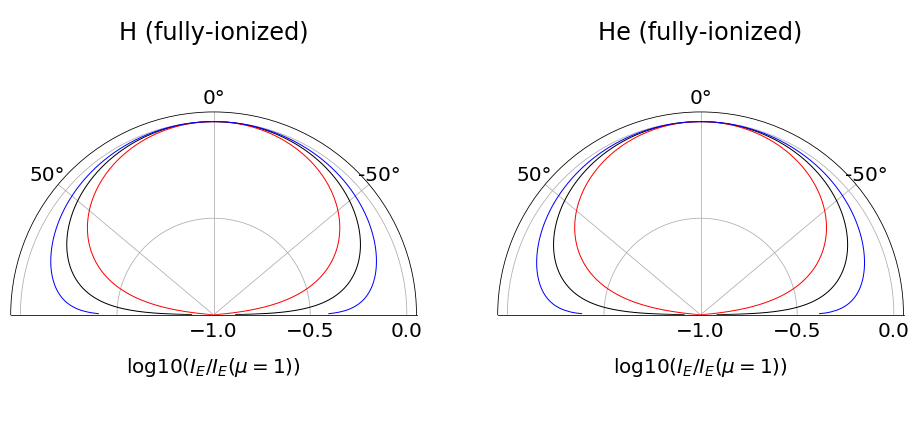

In [12]:
# keV (local comoving frame)
E = np.ones(1000) * 0.2

# cos(angle to local surface normal in comoving frame)
mu = np.linspace(0.01,1.0,1000)

fig = plt.figure(figsize=(16,8))

# Hydrogen

ax = fig.add_subplot(121, projection='polar')

ax.set_theta_direction(1)
ax.set_thetamin(-90.0)
ax.set_thetamax(90.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.0, 13.8]]*1000)

H_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                   atmosphere=H_fully,
                                                   extension='hot',
                                                   numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'k-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'k-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[5.5, 13.8]]*1000)

H_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                   atmosphere=H_fully,
                                                   extension='hot',
                                                   numTHREADS=2)


ax.plot(np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'r-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'r-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.5, 13.8]]*1000)

H_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                   atmosphere=H_fully,
                                                   extension='hot',
                                                   numTHREADS=2)


ax.plot(np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'b-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'b-', lw=1.0)

ax.set_rmax(0.05)
ax.set_rmin(-1)
ax.set_theta_zero_location("N")
ax.set_rticks([-1.0,-0.5, 0.0])
ax.set_xlabel('log10$(I_E/I_E(\mu=1))$')
ax.xaxis.set_label_coords(0.5, 0.15)
_ = ax.set_title('H (fully-ionized)', pad=-50)

# Helium

ax = fig.add_subplot(122, projection='polar')

ax.set_theta_direction(1)
ax.set_thetamin(-90.0)
ax.set_thetamax(90.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.0, 13.8]]*1000)

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     extension='hot',
                                                     numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'k-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'k-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[5.5, 13.8]]*1000)

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     extension='hot',
                                                     numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'r-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'r-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.5, 13.8]]*1000)

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     extension='hot',
                                                     numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'b-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'b-', lw=1.0)

ax.set_rmax(0.05)
ax.set_rmin(-1)
ax.set_theta_zero_location("N")
ax.set_rticks([-1.0,-0.5, 0.0])
ax.set_xlabel('log10$(I_E/I_E(\mu=1))$')
ax.xaxis.set_label_coords(0.5, 0.15)
_ = ax.set_title('He (fully-ionized)', pad=-50)

## Calculate the specific intensity indirectly via global variables

We can also calculate intensities by specifying spacetime coordinates at the surface and values for some set of global variables that control the radiation field.

In [13]:
xpsi.surface_radiation_field.intensity_from_globals?

In [14]:
# unimportant here; just use strict bounds
bounds = dict(mass = (None, None), 
              radius = (None, None),
              distance = (None, None),
              cos_inclination = (None, None))

spacetime = xpsi.Spacetime(bounds, dict(frequency = 1.0/(4.87e-3))) # J0030 spin

Creating parameter:
    > Named "frequency" with fixed value 2.053e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e-03, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+00, 2.000e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-02, 3.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [-1.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


In [15]:
# keV (local comoving frame)
E = np.logspace(-2.0, 0.5, 1000, base=10.0)

# cos(angle to local surface normal in comoving frame)
mu = np.ones(1000) * 0.5

In [16]:
colatitude = np.ones(1000) * 1.0 # radians
azimuth = np.zeros(1000)
phase = np.zeros(1000)
global_vars = np.array([6.11])  # just temperature (globally invariant local variable)

In [17]:
spacetime.params

[Spin frequency [Hz] = 2.053e+02,
 Gravitational mass [solar masses],
 Coordinate equatorial radius [km],
 Earth distance [kpc],
 Cosine of Earth inclination to rotation axis]

In [18]:
spacetime['radius'] = 12.0
spacetime['mass'] = 1.4
# we do not need the observer coordinates (typically handled
# by xpsi.Spacetime instances) to compute effective gravity so
# no need to set values

# the first 5 arguments are 1D arrays that specific a point sequence in the
# joint space of surface spacetime coordinates, energy, and angle
# if you have a set of such points that does not conform readily
# to a 1D array, write a custom wrapper to handle the structure
# in your point set
I_E = xpsi.surface_radiation_field.intensity_from_globals(E,
                                                          mu,
                                                          colatitude,
                                                          azimuth,
                                                          phase,
                                                          global_vars,       # -> eff. temp.
                                                          spacetime.R,       # -> eff. grav.
                                                          spacetime.zeta,    # -> eff. grav.
                                                          spacetime.epsilon, # -> eff. grav.
                                                          atmosphere=H_fully,
                                                          numTHREADS=2)

Note that only the `hot.pyx` extension is invoked here.

Let's plot the spectrum and also the spectrum generated by declaring the effective gravity directly above:

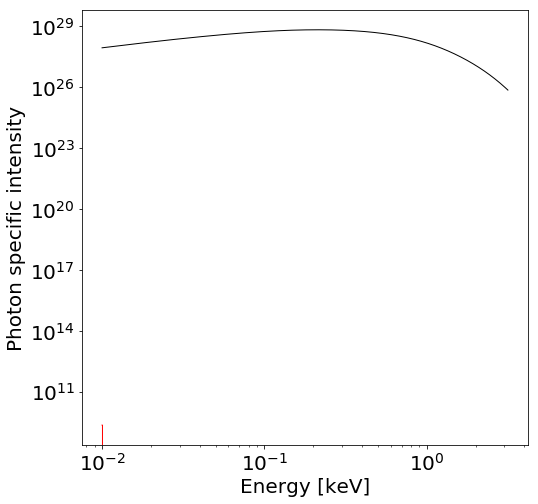

In [19]:
plt.figure(figsize=(8,8))

plt.plot(E, hot_I, 'k-', lw=1.0)
plt.plot(E, I_E, 'r-', lw=1.0)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Photon specific intensity')
_ = ax.set_xlabel('Energy [keV]')